# Summary

This notebook centers on predicting the maximum depth of anomalies in In-Line Inspection (ILI) data. Utilizing various machine learning techniques, the goal is to fill in missing values and forecast the future growth of anomalies. Accurately estimating anomaly depth is critical for assessing pipeline strength and ensuring safety. The process involves data exploration, cleaning, feature engineering, anomaly mapping, and advanced modeling. These steps offer valuable insights for managing pipeline integrity, enabling proactive maintenance and risk mitigation.

The ILI data for this study is publicly available from the [Mendeley Data repository](https://data.mendeley.com/datasets/c2h2jf5c54/1). The dataset, titled "Dataset for: Cross-country Pipeline Inspection Data Analysis and Testing of Probabilistic Degradation Models", was published on October 4, 2021, by Rioshar Yarveisy, Faisal Khan, and Rouzbeh Abbassi from Memorial University of Newfoundland and Macquarie University. The dataset includes four consecutive ILI data sets, which lack certain details such as coordinates, likely due to anonymization efforts.

# Introduction

Pipeline integrity management is crucial in ensuring the safety and reliability of gas and oil transportation. In-line inspection (ILI) tools are extensively used to detect and measure anomalies in pipelines. Accurately predicting the maximum depth of these anomalies is essential for proactive maintenance and risk mitigation. This notebook demonstrates a comprehensive workflow, from data loading and cleaning to advanced machine learning modeling, aimed at predicting anomaly depths effectively. Key steps in the process include:

**Data Exploration and Cleaning**: This involves exploratory data analysis (EDA) to understand the data distribution and identify patterns, handling duplicate records, and managing missing values.

**Feature Engineering**: We compute new features such as aspect ratio and area of anomalies, estimate the maximum depth using domain-specific calculations, and create cyclic features from angular measurements.

**Anomaly Mapping**: We match anomalies across different inspection years to track their growth and changes over time. This involves sophisticated matching algorithms to identify corresponding anomalies based on relative distances and orientations.

**Modeling**: We employ machine learning models, particularly the Hist Gradient Boosting Regressor, to predict the maximum depth of anomalies. This includes data preparation, model training, hyperparameter tuning, and evaluation.

**Prediction and Validation**: The predicted values are validated against actual measurements to ensure accuracy. We also compare the machine learning predictions with domain-specific estimates to highlight the added value of advanced modeling techniques.

The ILI data for this study is publicly available from the [Mendeley Data repository](https://data.mendeley.com/datasets/c2h2jf5c54/1). The dataset, titled "Dataset for: Cross-country Pipeline Inspection Data Analysis and Testing of Probabilistic Degradation Models," was published on October 4, 2021, by Rioshar Yarveisy, Faisal Khan, and Rouzbeh Abbassi from Memorial University of Newfoundland and Macquarie University. The dataset includes four consecutive ILI data sets, which lack certain details such as coordinates, likely due to anonymization efforts.

# Setup

## Import Dependencies

In [83]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv

import importlib
import tools
importlib.reload(tools)
from tools import EDA

In [51]:
# Load the environment variables from the .env file
load_dotenv(override=True)

True

## Loading the ILI Data

In [52]:
AnomaliesProc  = pd.read_csv(os.getenv("csv_file_name"))

### Rename Columns

In [53]:
from tools import rename_anomaly_columns

# Rename the columns
AnomaliesProc = rename_anomaly_columns(AnomaliesProc)

# Data Exploration and Cleaning

## EDA

### Max Depth (mm)

In [ ]:
# Create the EDA object
eda = EDA(AnomaliesProc)

In [ ]:
# plot the histogram of the max depth
eda.plot_histogram_max_depth('MaxDepth_mm')

In [ ]:
# Summary statistics
print(AnomaliesProc['MaxDepth_mm'].describe())

In [ ]:
# Calculate the percentiles and IQR
eda.calculate_percentiles_and_iqr('MaxDepth_mm')

In [ ]:
# Plot the boxplot
eda.plot_boxplot_max_depth('MaxDepth_mm')

### Linear Correlation

In [ ]:
eda.plot_correlation_matrix()

## Duplicate Values

In [54]:
# Check for duplicate rows
duplicates = AnomaliesProc.duplicated(keep=False)

# Display the duplicate rows
duplicate_rows = AnomaliesProc[duplicates]

# Print the duplicate rows
print("Duplicate rows in the dataframe:")
print(duplicate_rows)

Duplicate rows in the dataframe:
Empty DataFrame
Columns: [InspectionYear, GirthWeldNumber, JointLength_m, RelativeDistance_m, SeamOrientation_deg, StartPointDistance_m, StartPointOrientation_deg, EndPointDistance_m, EndPointOrientation_deg, SignificantPointRelDistance_m, SignificantPointOrientation_deg, WallThickness_mm, FeatureLength_mm, FeatureWidth_mm, MaxDepth_mm]
Index: []


## Missing Values

In [55]:
from tools import MissingValuesAnalyzer

# Create the MissingValuesAnalyzer object
MissingValuesAnalyzer = MissingValuesAnalyzer(AnomaliesProc)

### Identify Features w/ Missing Values

In [56]:
# Find columns with missing values
MissingValuesAnalyzer.find_missing_values()

Columns with missing values:
SeamOrientation_deg: 845310
EndPointDistance_m: 759683


### End Point Distance                 

In [57]:
# Apply the calculation only if the 'EndPointDistance_m' column has NaN values
AnomaliesProc['EndPointDistance_m'] = np.where(
    AnomaliesProc['EndPointDistance_m'].isna(),
    AnomaliesProc['StartPointDistance_m'] + AnomaliesProc['FeatureLength_mm'] / 1000,
    AnomaliesProc['EndPointDistance_m']
)

In [58]:
# Find the remaining columns with missing values
MissingValuesAnalyzer.find_missing_values()

Columns with missing values:
SeamOrientation_deg: 845310


### Seam Orientation             

### Handle Joints with Inconsistent Seam Orientation

In [59]:
# Handle joints with inconsistent seam orientation
MissingValuesAnalyzer.check_inconsistent_seam_orientation()


GirthWeldNumber 32:
  InspectionYear 1:
SeamOrientation_deg
0.0    12
  InspectionYear 3:
Series([], )
  InspectionYear 5:
SeamOrientation_deg
360.0    12
  InspectionYear 7:
SeamOrientation_deg
360.0    12

GirthWeldNumber 73:
  InspectionYear 1:
SeamOrientation_deg
38.0    2
  InspectionYear 3:
Series([], )
  InspectionYear 5:
SeamOrientation_deg
28.0    2
  InspectionYear 7:
SeamOrientation_deg
28.0    2

GirthWeldNumber 74:
  InspectionYear 1:
SeamOrientation_deg
24.0    4
  InspectionYear 3:
Series([], )
  InspectionYear 5:
SeamOrientation_deg
14.0    2
  InspectionYear 7:
SeamOrientation_deg
14.0    2

GirthWeldNumber 77:
  InspectionYear 1:
SeamOrientation_deg
52.0    16
  InspectionYear 3:
Series([], )
  InspectionYear 5:
SeamOrientation_deg
38.0    13
  InspectionYear 7:
SeamOrientation_deg
38.0    19

GirthWeldNumber 81:
  InspectionYear 1:
SeamOrientation_deg
36.0    8
  InspectionYear 3:
Series([], )
  InspectionYear 5:
SeamOrientation_deg
20.0    5
  InspectionYear 7:
Sea

In [60]:
# Handle joints with inconsistent seam orientation
MissingValuesAnalyzer.handle_inconsistent_seam_orientation()


GirthWeldNumber 32:
  InspectionYear 1:
SeamOrientation_deg
360.0    12
  InspectionYear 3:
SeamOrientation_deg
360.0    17
  InspectionYear 5:
SeamOrientation_deg
360.0    12
  InspectionYear 7:
SeamOrientation_deg
360.0    12

GirthWeldNumber 73:
  InspectionYear 1:
SeamOrientation_deg
28.0    2
  InspectionYear 3:
SeamOrientation_deg
28.0    2
  InspectionYear 5:
SeamOrientation_deg
28.0    2
  InspectionYear 7:
SeamOrientation_deg
28.0    2

GirthWeldNumber 74:
  InspectionYear 1:
SeamOrientation_deg
14.0    4
  InspectionYear 3:
SeamOrientation_deg
14.0    4
  InspectionYear 5:
SeamOrientation_deg
14.0    2
  InspectionYear 7:
SeamOrientation_deg
14.0    2

GirthWeldNumber 77:
  InspectionYear 1:
SeamOrientation_deg
38.0    16
  InspectionYear 3:
SeamOrientation_deg
38.0    22
  InspectionYear 5:
SeamOrientation_deg
38.0    13
  InspectionYear 7:
SeamOrientation_deg
38.0    19

GirthWeldNumber 81:
  InspectionYear 1:
SeamOrientation_deg
20.0    8
  InspectionYear 3:
SeamOrientati

In [61]:
# Find and report the inconsistent joints
MissingValuesAnalyzer.find_and_report_inconsistent_joints()

All joints have consistent seam orientations.


### Handle Joints with missing Values   

#### Permutation using Mean

In [62]:
# Fill the missing seam orientation values with the average. Since each joints has a unique seam orientation, the average is the same as the original value.
AnomaliesProc = MissingValuesAnalyzer.fill_missing_seam_orientation_w_average()

In [63]:
# Find columns with missing values. The remaining missing values occurs in joints with no seam orientation across all inspection years. For those, we can use fill forward from the previous joint.
MissingValuesAnalyzer.find_missing_values()

Columns with missing values:
SeamOrientation_deg: 15747


#### Permutation using Fill Forward

In [64]:
# Fill the missing seam orientation values with the previous value
AnomaliesProc =  MissingValuesAnalyzer.fill_missing_seam_orientation_w_ffill()

In [65]:
# Find columns with missing values
MissingValuesAnalyzer.find_missing_values()

No missing values found in 'SeamOrientation_deg' column.


# Modeling

##  Predicting Anomaly Depth: A Machine Learning Approach
This exercise aims to predict the maximum depth of anomalies for educational purposes. The applications of this prediction include filling in missing data and forecasting the future growth of anomalies, particularly the maximum depth.

### Data Manipulation (Optional)
Random removal of MaxDepth data to then predict them using ML for educational purposes.

In [ ]:
# Randomly remove 5% of the values from MaxDepth_mm column
# mask = np.random.rand(len(AnomaliesProc)) < 0.01  # Adjusted to 1%
# AnomaliesProc.loc[mask, 'MaxDepth_mm'] = np.nan

# Verify the number of missing values
# print(f"Number of missing values: {AnomaliesProc['MaxDepth_mm'].isnull().sum()}")

We skip the model selection and hyperparameter tuning step and use Hist Gradient Boosting Regressor with default hyperparameter to predict the records with missing max_depth_mm values.

### Importing Dependencies

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_hist_gradient_boosting 
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from skopt import BayesSearchCV
from skopt.space import Integer, Real
from skopt.callbacks import DeltaYStopper

In [84]:
# Make a copy of the DataFrame
AnomaliesProc_ML_Ready = AnomaliesProc.copy()

### Feature Engineering

In [85]:
from tools import FeatureEngineering

# Create an instance of the class with your dataframe
feature_engineering = FeatureEngineering(AnomaliesProc_ML_Ready)

#### Aspect Ratio and Area

In [86]:
# Compute the aspect ratio
AnomaliesProc_ML_Ready = feature_engineering.compute_aspect_ratio()

# Calculate the feature area
AnomaliesProc_ML_Ready = feature_engineering.calculate_feature_area()

#### Estimated Max Depth of Anomaly

In [87]:
# Add the estimated max depth
AnomaliesProc_ML_Ready = feature_engineering.add_estimated_max_depth()

In [93]:
AnomaliesProc_ML_Ready[['FeatureArea_mm2','FeatureLength_mm', 'WallThickness_mm', 'MaxDepth_mm',
        'estimated_max_depth_mm']]

,FeatureArea_mm2,FeatureLength_mm,WallThickness_mm,MaxDepth_mm,estimated_max_depth_mm
0,329.867229,15.0,7.1,0.92,0.000000
34,387.986693,13.0,7.1,0.64,0.000000
35,283.528737,19.0,7.1,0.64,0.000000
36,673.871624,26.0,7.1,0.07,0.000000
37,12893.096250,54.0,7.1,0.07,0.000000
...,...,...,...,...,...
3198391,7290.065753,78.0,7.1,0.07,0.000000
3198392,11769.976877,118.0,7.1,0.35,0.000000
3198393,763.407015,27.0,7.1,0.71,0.000000
3198384,1256.637061,20.0,7.1,0.07,0.000000


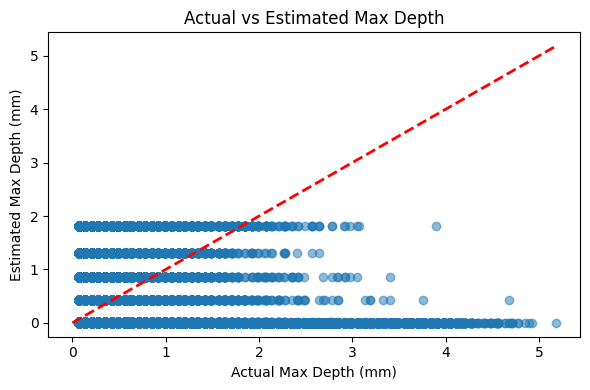

In [81]:
# Create a scatter plot
plt.figure(figsize=(6, 4))
plt.scatter(AnomaliesProc_ML_Ready['MaxDepth_mm'], 
            AnomaliesProc_ML_Ready['estimated_max_depth_mm'], 
            alpha=0.5)
plt.plot([0, AnomaliesProc_ML_Ready['MaxDepth_mm'].max()], 
         [0, AnomaliesProc_ML_Ready['MaxDepth_mm'].max()], 
         'r--', lw=2)  # Add a diagonal line for reference
plt.xlabel('Actual Max Depth (mm)')
plt.ylabel('Estimated Max Depth (mm)')
plt.title('Actual vs Estimated Max Depth')
plt.tight_layout()
plt.show()

In [ ]:
# Create a histogram of the differences
plt.figure(figsize=(6, 4))
differences = AnomaliesProc_ML_Ready['MaxDepth_mm'] - AnomaliesProc_ML_Ready['estimated_max_depth_mm']
sns.histplot(differences, kde=True)
plt.xlabel('(Actual Depth - Estimated Depth) (mm)')
plt.ylabel('Frequency')
plt.title('Distribution of Differences between Actual and Estimated Depth')
plt.axvline(x=0, color='r', linestyle='--')
plt.xlim(0, 1)
plt.ylim(0, 100000)
plt.tight_layout()
plt.show()


#### Radial to Cyclic Features

In [ ]:
# List of columns containing angular measurements
angle_columns = ['SeamOrientation_deg', 'StartPointOrientation_deg', 'EndPointOrientation_deg', 'SignificantPointOrientation_deg']

# Function to convert degrees to radians
def deg_to_rad(deg):
    return deg * np.pi / 180

# Create new sine and cosine features for each angular measurement
for col in angle_columns:
    # Convert to radians
    AnomaliesProc_ML_Ready[f'{col}_rad'] = AnomaliesProc_ML_Ready[col].apply(deg_to_rad)
    
    # Create sine component
    AnomaliesProc_ML_Ready[f'{col}_sin'] = np.sin(AnomaliesProc_ML_Ready[f'{col}_rad'])
    
    # Create cosine component
    AnomaliesProc_ML_Ready[f'{col}_cos'] = np.cos(AnomaliesProc_ML_Ready[f'{col}_rad'])

    # drop the original columns
    # AnomaliesProc_ML_Ready.drop(columns=[col, f'{col}_rad'], inplace=True)


### Anomaly Mapping

In [ ]:
# print('min Anomaly mapped df', np.min(Anomaly_mapped_df.GirthWeldNumber))
# print('max Anomaly mapped df', np.max(Anomaly_mapped_df.GirthWeldNumber))

# print('min Anomaly mapping df', np.min(Anomaly_mapping_df.GirthWeldNumber))
# print('max Anomaly mapping df', np.max(Anomaly_mapping_df.GirthWeldNumber))

# print('min Anomalies Proc ML Ready', np.min(AnomaliesProc_ML_Ready.GirthWeldNumber))
# print('max Anomalies Proc ML Ready', np.max(AnomaliesProc_ML_Ready.GirthWeldNumber))

In [ ]:
# class Anomaly_mapping:
#     def __init__(self, df):
#         self.df = df

#     def sort_dataframe(self):
#         return self.df.sort_values(['GirthWeldNumber', 'InspectionYear', 'RelativeDistance_m'])

#     def filter_girthweld(self, girth_weld_number):
#         return self.df[self.df.GirthWeldNumber == girth_weld_number]

#     def get_unique_years(self):
#         return self.df['InspectionYear'].unique()

#     def process_years(self, years):
#         results = []
#         for i in range(1, len(years)):
#             results.extend(self.match_anomalies(years[i-1], years[i]))
#         return results

#     def match_anomalies(self, previous_year, current_year):
#         previous_year_data = self.df[self.df['InspectionYear'] == previous_year].reset_index(drop=True)
#         current_year_data = self.df[self.df['InspectionYear'] == current_year].copy().reset_index(drop=True)
#         matches = []

#         for _, anomaly in current_year_data.iterrows():
#             previous_year_data['DistanceDiff'] = np.abs(anomaly['RelativeDistance_m'] - previous_year_data['RelativeDistance_m'])
#             previous_year_data['OrientationDiff'] = np.abs(anomaly['SignificantPointOrientation_deg'] - previous_year_data['SignificantPointOrientation_deg'])

#             potential_matches = previous_year_data[(previous_year_data['DistanceDiff'] <= 0.05) & 
#                                                 (previous_year_data['OrientationDiff'] <= 5)].copy()

#             if not potential_matches.empty:
#                 potential_matches['TotalDiff'] = potential_matches['DistanceDiff'] + potential_matches['OrientationDiff']
#                 closest_match_index = potential_matches['TotalDiff'].idxmin()
#                 closest_match = previous_year_data.loc[closest_match_index]
#                 matches.append(self.create_result_dict(anomaly, closest_match, previous_year, True))
#             else:
#                 matches.append(self.create_result_dict(anomaly, None, previous_year, False))

#         return matches

#     def process_first_year(self, first_year):
#         first_year_data = self.df[self.df['InspectionYear'] == first_year].reset_index(drop=True)
#         matches = []

#         for _, anomaly in first_year_data.iterrows():
#             matches.append(self.create_result_dict(anomaly, None, first_year, False))

#         return matches

#     def create_result_dict(self, anomaly, closest_match, previous_year, is_old):
#         if is_old:
#             length_change = anomaly['FeatureLength_mm'] - closest_match['FeatureLength_mm']
#             width_change = anomaly['FeatureWidth_mm'] - closest_match['FeatureWidth_mm']
#             depth_change = anomaly['MaxDepth_mm'] - closest_match['MaxDepth_mm']
#             distance_diff = anomaly['RelativeDistance_m'] - closest_match['RelativeDistance_m']
#             orientation_diff = anomaly['SignificantPointOrientation_deg'] - closest_match['SignificantPointOrientation_deg']
#             return {
#                 'GirthWeldNumber': anomaly['GirthWeldNumber'],
#                 'InspectionYear': anomaly['InspectionYear'],
#                 'RelativeDistance_m': anomaly['RelativeDistance_m'],
#                 'FeatureLength_mm': anomaly['FeatureLength_mm'],
#                 'FeatureWidth_mm': anomaly['FeatureWidth_mm'],
#                 'MaxDepth_mm': anomaly['MaxDepth_mm'],
#                 'SignificantPointOrientation_deg': anomaly['SignificantPointOrientation_deg'],
#                 'Prev_InspectionYear': previous_year,
#                 'Prev_RelativeDistance_m': closest_match['RelativeDistance_m'],
#                 'Prev_FeatureLength_mm': closest_match['FeatureLength_mm'],
#                 'Prev_FeatureWidth_mm': closest_match['FeatureWidth_mm'],
#                 'Prev_MaxDepth_mm': closest_match['MaxDepth_mm'],
#                 'Prev_SignificantPointOrientation_deg': closest_match['SignificantPointOrientation_deg'],
#                 'LengthChange': length_change,
#                 'WidthChange': width_change,
#                 'DepthChange': depth_change,
#                 'DistanceDiff': distance_diff,
#                 'OrientationDiff': orientation_diff,
#                 'Tag': 'old'
#             }
#         else:
#             return {
#                 'GirthWeldNumber': anomaly['GirthWeldNumber'],
#                 'InspectionYear': anomaly['InspectionYear'],
#                 'RelativeDistance_m': anomaly['RelativeDistance_m'],
#                 'FeatureLength_mm': anomaly['FeatureLength_mm'],
#                 'FeatureWidth_mm': anomaly['FeatureWidth_mm'],
#                 'MaxDepth_mm': anomaly['MaxDepth_mm'],
#                 'SignificantPointOrientation_deg': anomaly['SignificantPointOrientation_deg'],
#                 'Prev_InspectionYear': np.nan,
#                 'Prev_RelativeDistance_m': np.nan,
#                 'Prev_FeatureLength_mm': np.nan,
#                 'Prev_FeatureWidth_mm': np.nan,
#                 'Prev_MaxDepth_mm': np.nan,
#                 'Prev_SignificantPointOrientation_deg': np.nan,
#                 'LengthChange': np.nan,
#                 'WidthChange': np.nan,
#                 'DepthChange': np.nan,
#                 'DistanceDiff': np.nan,
#                 'OrientationDiff': np.nan,
#                 'Tag': 'new'
#             }

#     def process_data(self, girth_weld_number):
#         self.df = self.sort_dataframe()
#         self.df = self.filter_girthweld(girth_weld_number)
#         years = self.get_unique_years()

#         results = []
#         if len(years) >= 1:
#             results.extend(self.process_first_year(years[0]))
#         if len(years) > 1:
#             results.extend(self.process_years(years))

#         anomalies_changes = pd.DataFrame(results)
#         anomalies_changes = anomalies_changes.sort_values(['InspectionYear', 'RelativeDistance_m'])

#         self.df = anomalies_changes.merge(
#             self.df, 
#             on=['GirthWeldNumber', 'RelativeDistance_m', 'InspectionYear', 'SignificantPointOrientation_deg'], 
#             how='left', 
#             suffixes=('', '_dup')
#         )
#         self.df = self.df.drop(columns=[col for col in self.df.columns if '_dup' in col])

#         return self.df

In [ ]:
import importlib
import tools

# Reload the module to reflect the changes
importlib.reload(tools)

from tools import Anomaly_mapping, plot_anomalies_by_year, detect_errors

In [ ]:
# Get all unique girth weld numbers
girth_weld_numbers = AnomaliesProc_ML_Ready.GirthWeldNumber.unique()

# Initialize an empty list to store results for all girth weld numbers
all_results = []

# Iterate over all girth weld numbers
for gw_num in girth_weld_numbers:
    # Create an instance of the Anomaly_mapping class
    mapper = Anomaly_mapping(AnomaliesProc_ML_Ready)
    print(f"Processing girth weld number: {gw_num}")
    try:
        # Process the data for the current girth weld number
        AnomaliesProc_Mapped_single = mapper.process_data(girth_weld_number=gw_num)
        
        # Check if the result is empty
        if AnomaliesProc_Mapped_single.empty:
            print(f"No data found for girth weld number: {gw_num}")
            continue
        
        # Print the columns of the result for debugging
        print(f"Columns in result: {AnomaliesProc_Mapped_single.columns.tolist()}")
        
        # Check if required columns are present
        required_columns = ['InspectionYear', 'RelativeDistance_m', 'GirthWeldNumber']
        missing_columns = [col for col in required_columns if col not in AnomaliesProc_Mapped_single.columns]
        
        if missing_columns:
            print(f"Missing columns for girth weld number {gw_num}: {missing_columns}")
            continue
        
        # Add the results to the list
        all_results.append(AnomaliesProc_Mapped_single)
    except Exception as e:
        print(f"Error processing girth weld number {gw_num}: {str(e)}")

# Combine all results into a single DataFrame
if all_results:
    AnomaliesProc_Mapped = pd.concat(all_results, ignore_index=True)

    # Sort the final DataFrame
    AnomaliesProc_Mapped = AnomaliesProc_Mapped.sort_values(['GirthWeldNumber', 'InspectionYear', 'RelativeDistance_m'])

    # Reset the index
    AnomaliesProc_Mapped = AnomaliesProc_Mapped.reset_index(drop=True)

    # Print the shape of the final DataFrame to verify
    print(f"Final AnomaliesProc_Mapped shape: {AnomaliesProc_Mapped.shape}")
    print(f"Columns in final DataFrame: {AnomaliesProc_Mapped.columns.tolist()}")
else:
    print("No valid results were processed.")

#### Processing Anomalies

In [ ]:
# Define the increment size
increment_size = 1000
relative_distance_threshold = 0.1  # m
orientation_threshold = 10  # deg

# Find the maximum GirthWeldNumber
max_girth_weld_number = AnomaliesProc_ML_Ready['GirthWeldNumber'].max()

# Loop through the data in increments of 1000
for start in range(0, max_girth_weld_number + increment_size, increment_size):
    end = start + increment_size
    subset_df = AnomaliesProc_ML_Ready[(AnomaliesProc_ML_Ready.GirthWeldNumber >= start) & 
                                       (AnomaliesProc_ML_Ready.GirthWeldNumber < end)]
    if not subset_df.empty:
        mapper = Anomaly_mapping(subset_df, relative_distance_threshold, orientation_threshold)
        mapped_subset = mapper.process_all_girth_welds()
        
        # Save the mapped subset to a file
        file_name = f'../Dataset/processed_data/Anomaly_mapped_df_{start}_{end}.csv'
        mapped_subset.to_csv(file_name, index=False)
        
        # Reset the results list
        results = []

In [ ]:
import glob

# Define the path to the saved CSV files
path = '../Dataset/processed_data/'  # Adjust this path if your files are in a different directory
all_files = glob.glob(path + "Anomaly_mapped_df_*.csv")

# Initialize an empty list to store the dataframes
dataframes = []

# Loop through the list of files and read each one into a dataframe
for file in all_files:
    df = pd.read_csv(file)
    dataframes.append(df)

# Concatenate all the dataframes into a single dataframe
Anomaly_mapped_df = pd.concat(dataframes, ignore_index=True)

In [ ]:
# # Create an instance of the Anomaly_mapping class
# mapper = Anomaly_mapping(Anomaly_mapping_df)

# # Run the process_all_girth_welds method
# AnomaliesProc_Mapped = mapper.process_all_girth_welds()

In [ ]:
# Optionally, you can save this to a CSV file
Anomaly_mapped_df_file_path = '../Dataset/processed_data/AnomaliesProc_Mapped_All_GirthWelds.csv'
Anomaly_mapped_df.to_csv(Anomaly_mapped_df_file_path, index=False)

In [ ]:
# Detect errors in mapped anomalies
Anomaly_mapped_df['ErrorClassification'] = Anomaly_mapped_df.apply(detect_errors, axis=1)

# Save the updated DataFrame to a CSV file
Anomaly_mapped_validated_df_file_path = '../Dataset/processed_data/AnomaliesProc_Mapped_All_GirthWelds_Validated.csv'
Anomaly_mapped_df.to_csv(Anomaly_mapped_validated_df_file_path, index=False)

In [ ]:
# Save the updated DataFrame to a CSV file
Anomaly_mapped_validated_df_file_path = '../Dataset/processed_data/AnomaliesProc_Mapped_All_GirthWelds_Validated.csv'

Anomaly_mapped_df = pd.read_csv(Anomaly_mapped_validated_df_file_path)

In [ ]:
plot_anomalies_by_year(Anomaly_mapped_df, 14, figsize=(15, 3))

**Erroneous Record Classification**

In [ ]:
ErrorClassification_true = Anomaly_mapped_df[Anomaly_mapped_df.ErrorClassification == 'Error']
ErrorClassification_false = Anomaly_mapped_df[Anomaly_mapped_df.ErrorClassification == 'Okay']

print(f"number of erroneous records: {len(ErrorClassification_true)}")
print(f"number of correct records:  {len(ErrorClassification_false)}")
print(f"percentage of erroneous records: {len(ErrorClassification_true) / len(Anomaly_mapped_df) * 100:.2f}%\n")

old_records = Anomaly_mapped_df[Anomaly_mapped_df.Tag == 'old']
new_records = Anomaly_mapped_df[Anomaly_mapped_df.Tag == 'new']

print(f"number of old records: {len(old_records)}")
print(f"number of new records: {len(new_records)}")
print(f"percentage of old records: {len(old_records) / len(Anomaly_mapped_df) * 100:.2f}%")

In [ ]:
# Filter the DataFrame to include only the 'Okay' records
Filtered_Anomaly_mapped_df = Anomaly_mapped_df[Anomaly_mapped_df.ErrorClassification == 'Okay']

# Filter the DataFrame to include only the 'old' and 'new' records
Old_Filtered_Anomaly_mapped_df = Filtered_Anomaly_mapped_df[Filtered_Anomaly_mapped_df.Tag == 'old']
New_Filtered_Anomaly_mapped_df = Filtered_Anomaly_mapped_df[Filtered_Anomaly_mapped_df.Tag == 'new']

#### Add Second Previous Inspection Year Features

In [ ]:
DPrev_Old_Filtered_Anomaly_mapped_df = Old_Filtered_Anomaly_mapped_df.copy()

# Initialize new columns for DPrev values in the copied DataFrame
DPrev_Old_Filtered_Anomaly_mapped_df['DPrev_RelativeDistance_m'] = None
DPrev_Old_Filtered_Anomaly_mapped_df['DPrev_FeatureLength_mm'] = None
DPrev_Old_Filtered_Anomaly_mapped_df['DPrev_FeatureWidth_mm'] = None
DPrev_Old_Filtered_Anomaly_mapped_df['DPrev_MaxDepth_mm'] = None
DPrev_Old_Filtered_Anomaly_mapped_df['DPrev_SignificantPointOrientation_deg'] = None

# Iterate through each row to find and assign DPrev values
total_rows = len(DPrev_Old_Filtered_Anomaly_mapped_df)
for index, row in DPrev_Old_Filtered_Anomaly_mapped_df.iterrows():
    # Get the current row's Prev values
    prev_relative_distance = row['Prev_RelativeDistance_m']
    prev_depth = row['Prev_MaxDepth_mm']
    prev_feature_length = row['Prev_FeatureLength_mm']
    prev_feature_width = row['Prev_FeatureWidth_mm']
    prev_orientation = row['Prev_SignificantPointOrientation_deg']
    
    # Find the row with matching RelativeDistance_m, MaxDepth_mm, FeatureLength_mm, FeatureWidth_mm, and SignificantPointOrientation_deg
    matching_row = DPrev_Old_Filtered_Anomaly_mapped_df[
        (DPrev_Old_Filtered_Anomaly_mapped_df['RelativeDistance_m'] == prev_relative_distance) & 
        (DPrev_Old_Filtered_Anomaly_mapped_df['MaxDepth_mm'] == prev_depth) &
        (DPrev_Old_Filtered_Anomaly_mapped_df['FeatureLength_mm'] == prev_feature_length) &
        (DPrev_Old_Filtered_Anomaly_mapped_df['FeatureWidth_mm'] == prev_feature_width) &
        (DPrev_Old_Filtered_Anomaly_mapped_df['SignificantPointOrientation_deg'] == prev_orientation)
    ]
    
    if not matching_row.empty:
        # Retrieve the corresponding Prev values from the matching row
        dprev_relative_distance = matching_row['Prev_RelativeDistance_m'].values[0]
        dprev_feature_length = matching_row['Prev_FeatureLength_mm'].values[0]
        dprev_feature_width = matching_row['Prev_FeatureWidth_mm'].values[0]
        dprev_max_depth = matching_row['Prev_MaxDepth_mm'].values[0]
        dprev_orientation = matching_row['Prev_SignificantPointOrientation_deg'].values[0]
        
        # Assign these DPrev values to the original row
        DPrev_Old_Filtered_Anomaly_mapped_df.at[index, 'DPrev_RelativeDistance_m'] = dprev_relative_distance
        DPrev_Old_Filtered_Anomaly_mapped_df.at[index, 'DPrev_FeatureLength_mm'] = dprev_feature_length
        DPrev_Old_Filtered_Anomaly_mapped_df.at[index, 'DPrev_FeatureWidth_mm'] = dprev_feature_width
        DPrev_Old_Filtered_Anomaly_mapped_df.at[index, 'DPrev_MaxDepth_mm'] = dprev_max_depth
        DPrev_Old_Filtered_Anomaly_mapped_df.at[index, 'DPrev_SignificantPointOrientation_deg'] = dprev_orientation

    # Print progress
    if index % 100 == 0 or index == total_rows - 1:
        print(f"Processed {index + 1} / {total_rows} rows")

In [ ]:
Old_Filtered_Anomaly_mapped_df.to_csv('../Dataset/processed_data/Old_Filtered_Anomaly_mapped_df.csv', index=False)
DPrev_Old_Filtered_Anomaly_mapped_df.to_csv('../Dataset/processed_data/DPrev_Old_Filtered_Anomaly_mapped_df.csv', index=False)

In [ ]:
DPrev_Old_Filtered_Anomaly_mapped_df = pd.read_csv('../Dataset/processed_data/DPrev_Old_Filtered_Anomaly_mapped_df.csv')

### Outlier Removal

In [ ]:
# Calculate Z-scores for all numeric columns
z_scores = np.abs(zscore(DPrev_Old_Filtered_Anomaly_mapped_df[['MaxDepth_mm', 'FeatureWidth_mm', 'FeatureLength_mm', 'InspectionYear']], nan_policy='omit'))

# Create a mask for non-outlier data (within 3 standard deviations)
mask = (z_scores < 3).all(axis=1)

# Apply the mask to remove outliers
DPrev_Old_Filtered_Anomaly_mapped_df = DPrev_Old_Filtered_Anomaly_mapped_df[mask]

In [ ]:
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(contamination=0.05)
outliers = iso_forest.fit_predict(DPrev_Old_Filtered_Anomaly_mapped_df[['MaxDepth_mm', 'FeatureWidth_mm', 'FeatureLength_mm', 'InspectionYear','SignificantPointRelDistance_m']])

# Keep only the inliers
DPrev_Old_Filtered_Anomaly_mapped_df = DPrev_Old_Filtered_Anomaly_mapped_df[outliers == 1]


In [ ]:
np.unique(DPrev_Old_Filtered_Anomaly_mapped_df.InspectionYear)

### Class Imbalance

In [ ]:
class_counts = Old_Filtered_Anomaly_mapped_df['MaxDepth_mm'].value_counts().sort_index()
print(class_counts)

### Fitting Classification Model

In [ ]:
# from sklearn.preprocessing import LabelEncoder

# # Create a Series from MaxDepth_mm to preserve the index
# target_series = AnomaliesProc.MaxDepth_mm

# le = LabelEncoder()
# target = pd.Series(le.fit_transform(target_series), index=target_series.index)

# # Keep all features, including rows where target is an outlier
# features = AnomaliesProc_ML_Ready[['FeatureWidth_mm', 
#                                    'FeatureLength_mm', 
#                                    'InspectionYear', 
#                                    'GirthWeldNumber',
#                                    'StartPointDistance_m',
#                                    'StartPointOrientation_deg', 
#                                    'StartPointOrientation_deg_sin',  # New
#                                    'StartPointOrientation_deg_cos',  # New
#                                    'EndPointDistance_m',
#                                    'EndPointOrientation_deg', 
#                                    'EndPointOrientation_deg_sin',    # New
#                                    'EndPointOrientation_deg_cos',    # New
#                                    'SignificantPointRelDistance_m',
#                                    'SignificantPointOrientation_deg',
#                                    'SignificantPointOrientation_deg_sin',  # New
#                                    'SignificantPointOrientation_deg_cos',  # New
#                                    'AspectRatio',
#                                    'FeatureArea_mm2']]

# # Find common indices
# common_indices = features.index.intersection(target.index)

# # Filter both features and target to keep only rows with common indices
# features = features.loc[common_indices]
# target = target.loc[common_indices]

# # Apply standard scaling
# scaler = StandardScaler()
# features_scaled = scaler.fit_transform(features)

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

In [ ]:
# # Define the search space
# search_spaces = {
#     'learning_rate': Real(0.01, 0.5, prior='log-uniform'),
#     'max_iter': Integer(100, 500),
#     'max_depth': Integer(3, 10),
#     'min_samples_leaf': Integer(5, 50),
#     'l2_regularization': Real(1e-6, 1e-2, prior='log-uniform')
# }

In [ ]:
# from sklearn.ensemble import HistGradientBoostingClassifier

# # Initialize the base model
# base_model = HistGradientBoostingClassifier(random_state=42)

In [ ]:
# bayes_search = BayesSearchCV(
#     base_model,
#     search_spaces,
#     n_iter=50,
#     cv=5,
#     n_jobs=-1,
#     random_state=42,
#     scoring='accuracy',
# )

In [ ]:
# # Perform the search
# bayes_search.fit(X_train, y_train)

In [ ]:
# best_params = bayes_search.best_params_
# # Print the best parameters
# print("Best parameters found:")
# print(best_params)

In [ ]:
# # Initialize the model with the best parameters
# best_model = HistGradientBoostingClassifier(
#     random_state=42,
#     # **best_params
# )

In [ ]:
# # Perform the search
# best_model.fit(X_train, y_train)

In [ ]:
# # Make predictions
# y_pred = best_model.predict(X_test)

# # Evaluate the model
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy:.4f}")

# print("\nClassification Report:")
# print(classification_report(y_test, y_pred))

# # If you have more than two classes, use roc_auc_score with multi_class parameter
# if len(np.unique(y_test)) > 2:
#     roc_auc = roc_auc_score(y_test, best_model.predict_proba(X_test), multi_class='ovr')
# else:
#     roc_auc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])
# print(f"\nROC AUC Score: {roc_auc:.4f}")

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import roc_curve, auc
# from sklearn.preprocessing import label_binarize

# # Confusion Matrix Heatmap
# plt.figure(figsize=(10, 8))
# cm = confusion_matrix(y_test, y_pred)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# plt.title('Confusion Matrix')
# plt.ylabel('True Label')
# plt.xlabel('Predicted Label')
# plt.show()

In [ ]:
# n_classes = len(np.unique(y_test))

# # One-vs-Rest ROC curve for multiclass
# y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
# y_score = best_model.predict_proba(X_test)

# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(n_classes):
#     fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

# plt.figure(figsize=(8, 6))
# for i in range(n_classes):
#     plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {i} (AUC = {roc_auc[i]:.2f})')
# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve for Multi-class')
# plt.legend(loc="lower right")
# plt.show()

### Feature Importance

**Lasso**

In [ ]:
Old_Filtered_Anomaly_mapped_df = Old_Filtered_Anomaly_mapped_df.dropna()

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso

In [ ]:
# Define features and target
features = Old_Filtered_Anomaly_mapped_df.drop(
    columns=[
        'MaxDepth_mm',
        'Tag',
        'ErrorClassification',
        'Prev_MaxDepth_mm',
        'DepthChange',
        'LengthChange',
        'WidthChange',
        'DistanceDiff',
        'OrientationDiff'
    ]
)

target = Old_Filtered_Anomaly_mapped_df['MaxDepth_mm']

In [ ]:
# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [ ]:
# Split the data into training and testing sets
X_train_lasso, X_test_lasso, y_train_lasso, y_test_lasso = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

In [ ]:
# Define the grid of alpha values to search
alpha_grid = {'alpha': np.linspace(0.001, 1, 100)} 

In [ ]:
# Define the Lasso model
lasso = Lasso()

In [ ]:
# Set up the grid search with cross-validation
grid_search = GridSearchCV(estimator=lasso, param_grid=alpha_grid, cv=5, scoring='neg_mean_squared_error')

In [ ]:
# Fit the grid search to the data
grid_search.fit(X_train_lasso, y_train_lasso)

In [ ]:
# Get the best alpha value
# best_alpha = grid_search.best_params_['alpha']
best_alpha = 0.001
print(f"Best alpha value: {best_alpha}")

In [ ]:
# Fit the Lasso model with the best alpha
best_lasso = Lasso(alpha=best_alpha)
best_lasso.fit(X_train_lasso, y_train_lasso)

In [ ]:
# Get the coefficients
coefficients = best_lasso.coef_

In [ ]:
# Create a DataFrame to store feature names and their coefficients
importance_df = pd.DataFrame({'Feature': features.columns, 'Coefficient': coefficients})
importance_df.sort_values(by='Coefficient', ascending=False, inplace=True)

In [ ]:
# Plot the coefficients
plt.figure(figsize=(6, 12))
sns.barplot(x='Coefficient', y='Feature', data=importance_df)
plt.title('Feature Importance using Lasso Regression with Best Alpha')
plt.show()

**Ridge**

In [ ]:
# from sklearn.linear_model import Ridge

In [ ]:
# AnomaliesProc_dropna = AnomaliesProc.dropna()

In [ ]:
# ridge = Ridge()

In [ ]:
# Define features and target
# features = AnomaliesProc_dropna.drop(columns=['MaxDepth_mm'])
# target = AnomaliesProc_dropna['MaxDepth_mm']

In [ ]:
# Standardize the features
# scaler = StandardScaler()
# features_scaled = scaler.fit_transform(features)

In [ ]:
# Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

In [ ]:
# Define the grid of alpha values to search
# alpha_grid = {'alpha': np.linspace(0.01, 0.1, 5)}  # Test values from 0.0001 to 10

In [ ]:
# Set up the grid search with cross-validation
# grid_search_ridge = GridSearchCV(estimator=ridge, param_grid=alpha_grid, cv=5, scoring='neg_mean_squared_error')

In [ ]:
# Fit the grid search to the data
# grid_search_ridge.fit(X_train, y_train)

In [ ]:
# Get the best alpha value
# best_alpha = grid_search_ridge.best_params_['alpha']
# print(f"Best alpha value: {best_alpha}")

In [ ]:
# best_ridge_model = Ridge(alpha=best_alpha)
# best_ridge_model.fit(X_train, y_train)

In [ ]:
# Get the coefficients
# coefficients_ridge = best_ridge_model.coef_

In [ ]:
# Create a DataFrame to store feature names and their coefficients
# ridge_importance_df = pd.DataFrame({'Feature': features.columns, 'Coefficient': coefficients_ridge})
# ridge_importance_df.sort_values(by='Coefficient', ascending=False, inplace=True)

In [ ]:
# Plot the coefficients
# plt.figure(figsize=(6, 4))
# sns.barplot(x='Coefficient', y='Feature', data=ridge_importance_df)
# plt.title('Feature Importance using Ridge Regression with Best Alpha')
# plt.show()

### Fitting Regressor Model

In [ ]:
# Apply the mask to remove outliers only from the target variable
target = DPrev_Old_Filtered_Anomaly_mapped_df['MaxDepth_mm']

# Keep all features, including rows where target is an outlier
features = DPrev_Old_Filtered_Anomaly_mapped_df[[
        'GirthWeldNumber',
        'InspectionYear',
        'RelativeDistance_m',
        'FeatureLength_mm',
        'FeatureWidth_mm',
        'SignificantPointOrientation_deg',
        'Prev_InspectionYear',
        'Prev_RelativeDistance_m',
        'Prev_FeatureLength_mm',
        'Prev_FeatureWidth_mm',
        'Prev_MaxDepth_mm',
        'Prev_SignificantPointOrientation_deg',
        'DPrev_RelativeDistance_m',
        'DPrev_FeatureLength_mm',
        'DPrev_FeatureWidth_mm',
        'DPrev_MaxDepth_mm',
        'DPrev_SignificantPointOrientation_deg',
        'AspectRatio',
        'FeatureArea_mm2',
        'estimated_max_depth_mm',
        'SignificantPointOrientation_deg_sin',
        'SignificantPointOrientation_deg_cos',
        'LengthChange',
        'WidthChange',
        'DistanceDiff',
        'OrientationDiff'
    ]]

# Ensure features and target have the same index
features = features.loc[target.index]

# Apply standard scaling
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

**Addressing Class Imbalance**

In [ ]:
import numpy as np
from sklearn.preprocessing import KBinsDiscretizer
from imblearn.under_sampling import RandomUnderSampler

# Original discretized values
original_discretized_values = np.unique(target)

# Bin the target variable
n_bins = len(original_discretized_values)  # 13 unique values
kbins = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
target_binned = kbins.fit_transform(target.values.reshape(-1, 1)).reshape(-1)

# Convert target_binned to integers
target_binned = target_binned.astype(int)

# Calculate the frequency of each bin
bin_counts = np.bincount(target_binned)

# Define the desired number of samples for each bin
median_freq = np.median(bin_counts)
sampling_strategy = {i: min(count, int(median_freq)) for i, count in enumerate(bin_counts) if count > 0}

# Apply Random Undersampling
rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
features_resampled, target_resampled_binned = rus.fit_resample(features, target_binned)

# Map the binned target back to original discretized values
target_resampled = original_discretized_values[target_resampled_binned]

# Verify the resulting values match the original discretized values
print("Original discretized values:")
print(original_discretized_values)
print("Resulting values after resampling and mapping back:")
print(target_resampled)

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(features_resampled, target_resampled, test_size=0.2, random_state=42)

In [ ]:
# Define the search space
search_spaces = {
    'learning_rate': Real(0.01, 0.5, prior='log-uniform'),
    'max_iter': Integer(100, 500),
    'max_depth': Integer(3, 10),
    'min_samples_leaf': Integer(5, 50),
    'l2_regularization': Real(1e-6, 1e-2, prior='log-uniform')
}

In [ ]:
# Initialize the base model
base_model = HistGradientBoostingRegressor(random_state=42)

In [ ]:
# Define the callback
delta_y_stopper = DeltaYStopper(delta=0.001)

In [ ]:
# Initialize BayesSearchCV
bayes_search = BayesSearchCV(
    base_model,
    search_spaces,
    n_iter=50,
    cv=5,
    n_jobs=-1,
    random_state=42,
    scoring='neg_mean_squared_error')

In [ ]:
# Perform the search
bayes_search.fit(X_train[y_train.notnull()], y_train[y_train.notnull()], callback=[delta_y_stopper])

In [ ]:
best_params = bayes_search.best_params_
# Print the best parameters
print("Best parameters found:")
print(best_params)

In [ ]:
# Initialize the model with the best parameters
# best_model = HistGradientBoostingRegressor(
#     random_state=42,
#     **best_params
# )

best_model = HistGradientBoostingRegressor(
    l2_regularization=4.3693399475103194e-05,
    learning_rate=0.17233925413725915,
    max_depth=10,
    max_iter=226,
    min_samples_leaf=35,
    random_state=42
)

In [ ]:
# Perform the search
best_model.fit(X_train, y_train)

In [ ]:
# Make predictions on the test set
y_pred = best_model.predict(X_test)
y_true = y_test

# Evaluate the model
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
me = np.mean(y_true - y_pred)  # Mean Error


print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²) Score: {r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%")
print(f"Mean Error (ME): {me:.4f}")

**mapping**
- Root Mean Squared Error (RMSE): 0.0946
- Mean Absolute Error (MAE): 0.0607
- R-squared (R²) Score: 0.8994
- Mean Absolute Percentage Error (MAPE): 30.9938%
- Mean Error (ME): 0.0002

In [ ]:
# Assuming best_hgb_model is already fitted
# y_pred = best_model.predict(X_test)

# Create a DataFrame for easier plotting
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

In [ ]:
# Define a range of tolerance values
tolerances = np.arange(0.01, 0.51, 0.01)  # Tolerances from 1% to 30%

# Calculate prediction accuracy for each tolerance value
accuracies = []
for tolerance in tolerances:
    accuracy = np.mean(np.abs((y_test - y_pred) / y_test) < tolerance) * 100
    accuracies.append(accuracy)

# Plot the results
plt.figure(figsize=(6, 4))
plt.plot(tolerances * 100, accuracies, marker='o')
plt.xlabel('Tolerance (%)')
plt.ylabel('Prediction Accuracy (%)')
plt.title('Prediction Accuracy for Different Tolerance Ranges')
plt.grid(True)
plt.show()

In [ ]:
# Violin plot
plt.figure(figsize=(15, 6))
sns.violinplot(x='Actual', y='Predicted', data=results)

plt.xlabel('Max Depth (mm)')
plt.ylabel('Predicted Max Depth (mm)')
plt.title('Actual vs Predicted Values')
plt.show()

In [ ]:
# Adding a scatter plot for better visual comparison
sns.scatterplot(x='Actual', y='Predicted', data=results, color='blue', alpha=0.5)

# Adding a diagonal line
min_val = min(results['Actual'].min(), results['Predicted'].min())
max_val = max(results['Actual'].max(), results['Predicted'].max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

plt.xlabel('Max Depth (mm)')
plt.ylabel('Predicted Max Depth (mm)')
plt.title('Actual vs Predicted Values')
plt.show()

I think I should compared the ml prediction against the estimated max depth to show the value of ml prediction
then I can use the previous width and length change for future change and predict the depth and find the performance for 7th year.

In [ ]:
# # Predict missing values
# AnomaliesProc_ML_Ready.loc[AnomaliesProc_ML_Ready['MaxDepth_mm'].isnull(), 'MaxDepth_mm_predicted'] = best_model.predict(scaler.transform(features[AnomaliesProc_ML_Ready['MaxDepth_mm'].isnull()]))

# # Check for remaining missing values
# missing_values_remaining = AnomaliesProc_ML_Ready['MaxDepth_mm'].isnull().sum()

# print(f"Number of remaining missing values in 'MaxDepth_mm': {missing_values_remaining}")

In [ ]:
# # Show only the records where the max depth is predicted
# predicted_records = AnomaliesProc_ML_Ready[AnomaliesProc_ML_Ready['MaxDepth_mm'].isnull()]
# print(predicted_records)

### Fitting ARIMAX Model

In [ ]:
Old_Filtered_Anomaly_mapped_df.columns

In [ ]:
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming your dataframe is called 'Old_Filtered_Anomaly_mapped_df'
# Ensure your dataframe does not have any missing values
Old_Filtered_Anomaly_mapped_df = Old_Filtered_Anomaly_mapped_df.dropna()

# Define the list of exogenous variables
exogenous_vars = [
    'GirthWeldNumber',
    'RelativeDistance_m',
    'FeatureLength_mm',
    'FeatureWidth_mm',
    'SignificantPointOrientation_deg',
    'Prev_InspectionYear',
    'Prev_RelativeDistance_m',
    'Prev_FeatureLength_mm',
    'Prev_FeatureWidth_mm',
    'Prev_MaxDepth_mm',
    'Prev_SignificantPointOrientation_deg',
    'AspectRatio',
    'FeatureArea_mm2',
    'estimated_max_depth_mm',
    'SignificantPointOrientation_deg_sin',
    'SignificantPointOrientation_deg_cos'
]

In [ ]:
# Extract features (exogenous variables) and target
features = Old_Filtered_Anomaly_mapped_df[exogenous_vars]
target = Old_Filtered_Anomaly_mapped_df['MaxDepth_mm']
time_series = Old_Filtered_Anomaly_mapped_df['InspectionYear']

In [ ]:
# Scale the exogenous variables
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split the data into training and testing sets, ensuring temporal order is maintained
train_size = int(len(Old_Filtered_Anomaly_mapped_df) * 0.8)
X_train, X_test = features_scaled[:train_size], features_scaled[train_size:]
y_train, y_test = target[:train_size], target[train_size:]
time_train, time_test = time_series[:train_size], time_series[train_size:]

In [ ]:
# Fit the ARIMAX model using auto_arima for hyperparameter tuning
arimax_model = auto_arima(
    y=y_train,
    exogenous=X_train,
    seasonal=False,
    trace=True,
    error_action='ignore',  
    suppress_warnings=True,
    stepwise=True
)

# Print the summary of the best model found
print(arimax_model.summary())

In [ ]:
# Make predictions
predictions = arimax_model.predict(n_periods=len(y_test), exogenous=X_test)

# Evaluate the predictions
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R²: {r2}')

**mapping**
Root Mean Squared Error (RMSE): 0.0754
Mean Absolute Error (MAE): 0.0469
R-squared (R²) Score: 0.7848
Mean Absolute Percentage Error (MAPE): 29.9250%
Mean Error (ME): -0.0002

**No mapping**
Root Mean Squared Error (RMSE): 0.1551
Mean Absolute Error (MAE): 0.1112
R-squared (R²) Score: 0.6102
Mean Absolute Percentage Error (MAPE): 64.0431%
Mean Error (ME): 0.0001

### Predicting Anomaly Growth

In [ ]:
DPrev_Old_Filtered_Anomaly_mapped_df.columns

#### Additional Feature Engineering

In [ ]:
DPrev_Old_Filtered_Anomaly_mapped_df['Estimated_FeatureLength_mm'] = 2 * DPrev_Old_Filtered_Anomaly_mapped_df['Prev_FeatureLength_mm'] \
                                                                       - DPrev_Old_Filtered_Anomaly_mapped_df['DPrev_FeatureLength_mm']

DPrev_Old_Filtered_Anomaly_mapped_df['Estimated_FeatureWidth_mm'] = 2 * DPrev_Old_Filtered_Anomaly_mapped_df['Prev_FeatureWidth_mm'] \
                                                                        - DPrev_Old_Filtered_Anomaly_mapped_df['DPrev_FeatureWidth_mm']

DPrev_Old_Filtered_Anomaly_mapped_df['Powered_Prev_MaxDepth_mm'] = DPrev_Old_Filtered_Anomaly_mapped_df['Prev_MaxDepth_mm'] ** 2

In [ ]:
DPrev_Old_Filtered_Anomaly_mapped_df = DPrev_Old_Filtered_Anomaly_mapped_df.dropna()

#### Fitting the Regressor

In [ ]:
# Apply the mask to remove outliers only from the target variable
target = DPrev_Old_Filtered_Anomaly_mapped_df['MaxDepth_mm']

# Define the list of features
feature_columns = [
        'GirthWeldNumber',
        'InspectionYear',
        'RelativeDistance_m',
        'Estimated_FeatureLength_mm',
        'Estimated_FeatureWidth_mm',
        'SignificantPointOrientation_deg',
        'Prev_InspectionYear',
        'Prev_RelativeDistance_m',
        'Prev_FeatureLength_mm',
        'Prev_FeatureWidth_mm',
        'Prev_MaxDepth_mm',
        'Powered_Prev_MaxDepth_mm',
        'Prev_SignificantPointOrientation_deg',
        'DPrev_RelativeDistance_m',
        'DPrev_FeatureLength_mm',
        'DPrev_FeatureWidth_mm',
        'DPrev_MaxDepth_mm',
        'DPrev_SignificantPointOrientation_deg',
        'SignificantPointOrientation_deg_sin',
        'SignificantPointOrientation_deg_cos'
    ]

# Keep all features, including rows where target is an outlier
features = DPrev_Old_Filtered_Anomaly_mapped_df[feature_columns]

# Ensure features and target have the same index
features = features.loc[target.index]

# Apply standard scaling
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

**Addressing Class Imbalance**

In [ ]:
import numpy as np
from sklearn.preprocessing import KBinsDiscretizer
from imblearn.under_sampling import RandomUnderSampler

# Original discretized values
original_discretized_values = np.unique(target)

# Bin the target variable
n_bins = len(original_discretized_values)  # 13 unique values
kbins = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
target_binned = kbins.fit_transform(target.values.reshape(-1, 1)).reshape(-1)

# Convert target_binned to integers
target_binned = target_binned.astype(int)

# Calculate the frequency of each bin
bin_counts = np.bincount(target_binned)

# Define the desired number of samples for each bin
median_freq = np.median(bin_counts)
sampling_strategy = {i: min(count, int(median_freq)) for i, count in enumerate(bin_counts) if count > 0}

# Apply Random Undersampling
rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
features_resampled, target_resampled_binned = rus.fit_resample(features, target_binned)

# Map the binned target back to original discretized values
target_resampled = original_discretized_values[target_resampled_binned]

# Verify the resulting values match the original discretized values
print("Original discretized values:")
print(original_discretized_values)
print("Resulting values after resampling and mapping back:")
print(np.unique(target_resampled))

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(features_resampled, target_resampled, test_size=0.2, random_state=42)

In [ ]:
# Define the search space
search_spaces = {
    'learning_rate': Real(0.01, 0.5, prior='log-uniform'),
    'max_iter': Integer(100, 500),
    'max_depth': Integer(3, 10),
    'min_samples_leaf': Integer(5, 50),
    'l2_regularization': Real(1e-6, 1e-2, prior='log-uniform')
}

In [ ]:
# Initialize the base model
base_model = HistGradientBoostingRegressor(random_state=42)

In [ ]:
# Define the callback
delta_y_stopper = DeltaYStopper(delta=0.001)

In [ ]:
# Initialize BayesSearchCV
bayes_search = BayesSearchCV(
    base_model,
    search_spaces,
    n_iter=50,
    cv=5,
    n_jobs=-1,
    random_state=42,
    scoring='neg_mean_squared_error')

In [ ]:
# Perform the search
bayes_search.fit(X_train[y_train.notnull()], y_train[y_train.notnull()], callback=[delta_y_stopper])

In [ ]:
best_params = bayes_search.best_params_
# Print the best parameters
print("Best parameters found:")
print(best_params)

In [ ]:
# Initialize the model with the best parameters
# best_model = HistGradientBoostingRegressor(
#     random_state=42,
#     **best_params
# )

best_model = HistGradientBoostingRegressor(
    l2_regularization=0.0015783879853890563,
    learning_rate=0.055487920443684,
    max_depth=7,
    max_iter=386,
    min_samples_leaf=46,
    random_state=42
)

In [ ]:
# Perform the search
best_model.fit(X_train, y_train)

In [ ]:
# Make predictions on the test set
y_pred = best_model.predict(X_test)
y_true = y_test

# Evaluate the model
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
me = np.mean(y_true - y_pred)  # Mean Error


print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²) Score: {r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%")
print(f"Mean Error (ME): {me:.4f}")

**mapping**
Root Mean Squared Error (RMSE): 0.1090
Mean Absolute Error (MAE): 0.0729
R-squared (R²) Score: 0.7547
Mean Absolute Percentage Error (MAPE): 45.1916%
Mean Error (ME): -0.0002

In [ ]:
# Create a DataFrame for easier plotting
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

In [ ]:
# Define a range of tolerance values
tolerances = np.arange(0.01, 0.51, 0.01)  # Tolerances from 1% to 30%

# Calculate prediction accuracy for each tolerance value
accuracies = []
for tolerance in tolerances:
    accuracy = np.mean(np.abs((y_test - y_pred) / y_test) < tolerance) * 100
    accuracies.append(accuracy)

# Plot the results
plt.figure(figsize=(6, 4))
plt.plot(tolerances * 100, accuracies, marker='o')
plt.xlabel('Tolerance (%)')
plt.ylabel('Prediction Accuracy (%)')
plt.title('Prediction Accuracy for Different Tolerance Ranges')
plt.grid(True)
plt.show()

In [ ]:
# Violin plot
plt.figure(figsize=(15, 6))
sns.violinplot(x='Actual', y='Predicted', data=results)

plt.xlabel('Max Depth (mm)')
plt.ylabel('Predicted Max Depth (mm)')
plt.title('Actual vs Predicted Values')
plt.show()

In [ ]:
# Adding a scatter plot for better visual comparison
sns.scatterplot(x='Actual', y='Predicted', data=results, color='blue', alpha=0.5)

# Adding a diagonal line
min_val = min(results['Actual'].min(), results['Predicted'].min())
max_val = max(results['Actual'].max(), results['Predicted'].max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

plt.xlabel('Max Depth (mm)')
plt.ylabel('Predicted Max Depth (mm)')
plt.title('Actual vs Predicted Values')
plt.show()

In [ ]:
# Initialize an empty list to store the results
results = []

# Loop through each unique 'GirthWeldNumber'
for weld_number in Old_Filtered_Anomaly_mapped_df['GirthWeldNumber'].unique():
    # Filter for the specific 'GirthWeldNumber' and 'InspectionYear' 7
    filtered_df = Old_Filtered_Anomaly_mapped_df[
        (Old_Filtered_Anomaly_mapped_df['GirthWeldNumber'] == weld_number) &
        (Old_Filtered_Anomaly_mapped_df['InspectionYear'] == 7)
    ]
    
    # Skip if no rows found
    if filtered_df.empty:
        continue
    
    # Define the target and features
    target = filtered_df['MaxDepth_mm']
    features = filtered_df[feature_columns]
    
    # Ensure features and target have the same index
    features = features.loc[target.index]
    
    # Apply standard scaling
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    # Predict the max depth
    predictions = best_model.predict(features_scaled)
    
    # Create a new dataframe with the predicted values
    prediction_df = filtered_df.copy()
    prediction_df['Predicted_MaxDepth_mm'] = predictions
    
    # Append the results to the list
    results.append(prediction_df)

# Concatenate all the results into a single dataframe
Anomaly_prediction_Year9 = pd.concat(results)


## Test

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from scipy.stats import uniform, randint
from kerastuner.tuners import RandomSearch

# Assuming X_train and y_train are your input features and target variable

# Define the preprocessing steps
preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Preprocess the data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Reshape input to be 3D [samples, time steps, features] for LSTM
X_train_reshaped = X_train_preprocessed.reshape((X_train_preprocessed.shape[0], 1, X_train_preprocessed.shape[1]))
X_test_reshaped = X_test_preprocessed.reshape((X_test_preprocessed.shape[0], 1, X_test_preprocessed.shape[1]))

# Define the model-building function
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32),
                   activation='relu',
                   input_shape=(1, X_train_reshaped.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
                  loss='mse')
    return model

# Initialize the tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=50,
    executions_per_trial=3,
    directory='my_dir',
    project_name='lstm_tuning'
)

# Perform the search
tuner.search(X_train_reshaped, y_train, epochs=100, validation_split=0.2)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Train the best model
best_model.fit(X_train_reshaped, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Make predictions
y_pred = best_model.predict(X_test_reshaped).flatten()
y_true = y_test

# Evaluate the model
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
me = np.mean(y_true - y_pred)  # Mean Error

print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²) Score: {r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%")
print(f"Mean Error (ME): {me:.4f}")

**Hist Results**
Root Mean Squared Error (RMSE): 0.1090
Mean Absolute Error (MAE): 0.0729
R-squared (R²) Score: 0.7547
Mean Absolute Percentage Error (MAPE): 45.1916%
Mean Error (ME): -0.0002